use dataset from Kaggle
Labels:
1: phishing
0: legitimate

In [1]:
import pandas as pd

df = pd.read_csv("phishing_email.csv")
df.head()

df['label'].value_counts()



label
1    42891
0    39595
Name: count, dtype: int64

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')



CLEANING DATA since Emails contain html, urls, numbers and punctuation

In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "URL", text)
    text = re.sub(r"\d+", "NUMBER", text)
    text = re.sub(r"[^a-z\s]", "", text)
    
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    
    return " ".join(tokens)

#combine subject and body for cleaning
#phishing usually have important clues in both
df['clean_text'] = df['text_combined'].apply(clean_text)

df[['text_combined', 'clean_text']].head()



,text_combined,clean_text
0,hpl nom may 25 2001 see attached file hplno 52...,hpl nom may see attached file hplno xls hplno xls
1,nom actual vols 24 th forwarded sabrae zajac h...,nom actual vols th forwarded sabrae zajac hou ...
2,enron actuals march 30 april 1 201 estimated a...,enron actuals march april estimated actuals ma...
3,hpl nom may 30 2001 see attached file hplno 53...,hpl nom may see attached file hplno xls hplno xls
4,hpl nom june 1 2001 see attached file hplno 60...,hpl nom june see attached file hplno xls hplno...


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=5
)

X = vectorizer.fit_transform(df['clean_text'])
y = df['label']




In [5]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# model 1: Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [7]:
y_pred = model.predict(X_test)
print(y_pred[:10])
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[0 0 0 1 0 0 0 0 1 1]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      7935
           1       0.98      0.98      0.98      8563

    accuracy                           0.98     16498
   macro avg       0.98      0.98      0.98     16498
weighted avg       0.98      0.98      0.98     16498

[[7728  207]
 [ 130 8433]]


recall (phishing) = TP / (TP + FN): dont miss phishing emails
precision (phishing) = TP / (TP + FP): dont misclassify legit emails as phishing (avoid false alarms)F1-score: balance between precision and recall

True Positive (TP): 8433, correctly identified phishing emails
False Positive (FP): 207, legitimate emails incorrectly classified as phishing
True Negative (TN): 7728, correctly identified legitimate emails
False Negative (FN): 130, phishing emails missed by the model

=> very low errors only 207+130 = 337 misclassifications out of 16,498 emails

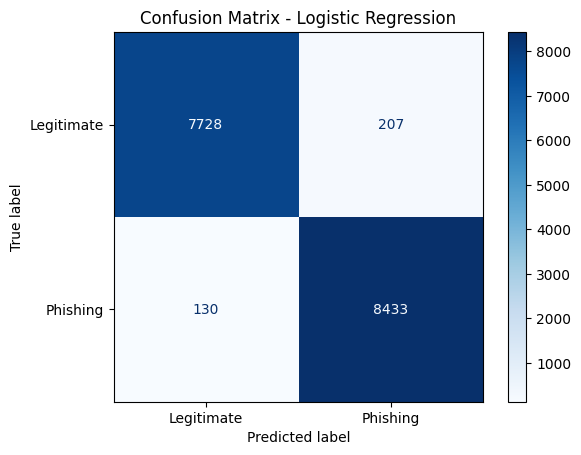

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["Legitimate", "Phishing"],
    cmap="Blues"
)

plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [ ]:
#get TOP Phishing words and TOP Legitimate words from the model
import pandas as pd
import numpy as np

# Get feature names from TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get Logistic Regression coefficients
coefficients = model.coef_[0]

# Create a DataFrame of words and their weights
coef_df = pd.DataFrame({
    "word": feature_names,
    "weight": coefficients
})

# Sort by highest positive weights (phishing indicators)
top_phishing_words = coef_df.sort_values(by="weight", ascending=False).head(20)

# Sort by most negative weights (legitimate indicators)
top_legitimate_words = coef_df.sort_values(by="weight").head(20)

print("Top Phishing Words:")
print(top_phishing_words)

print("\nTop Legitimate Words:")
print(top_legitimate_words)


Top Phishing Words:
               word    weight
2319  josemonkeyorg  6.415826
2070           http  5.231574
2476           life  4.975418
27          account  4.955372
2573           love  4.366637
3692         remove  4.359418
739           click  4.108555
2824          money  3.833705
2713           meds  3.740066
2236     investment  3.718322
4054           site  3.423878
1900             gr  3.399220
342             aug  3.398921
2828      monkeyorg  3.392369
395            bank  3.384526
4751         viagra  3.326031
3542        quality  3.262027
3256   phone mobile  3.210855
4820        watches  3.205336
3699        replica  3.146932

Top Legitimate Words:
             word     weight
4956        wrote -11.709181
1423        enron -10.807879
4440       thanks  -7.407500
3328           pm  -6.469569
4766        vince  -5.425382
2570       louise  -5.106439
4650   university  -4.940437
2106           im  -4.926724
3071     opensuse  -4.862083
3226         perl  -4.455013
4508    

In [11]:
#model 2: Naive Bayes
#fast and simple model for text classification (imbalance friendly)
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_nb_pred = nb_model.predict(X_test)
print(y_nb_pred[:10])
print(classification_report(y_test, y_nb_pred))
print(confusion_matrix(y_test, y_nb_pred))


[0 0 0 1 0 0 0 0 1 1]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7935
           1       0.98      0.93      0.95      8563

    accuracy                           0.95     16498
   macro avg       0.95      0.95      0.95     16498
weighted avg       0.96      0.95      0.95     16498

[[7786  149]
 [ 613 7950]]


In [12]:
#model 3: Random Forest
#tree-based model capturing complex patterns (non-linear patterns)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(y_pred[:10])

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


[0 0 0 1 0 0 0 0 1 1]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7935
           1       0.98      0.99      0.98      8563

    accuracy                           0.98     16498
   macro avg       0.98      0.98      0.98     16498
weighted avg       0.98      0.98      0.98     16498

[[7801  134]
 [ 127 8436]]


In [ ]:
#model 4: Support Vector Machine (SVM)
#effective in high-dimensional spaces
#works well for text classification tasks
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(y_pred[:10])

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



[0 0 0 1 0 0 0 0 1 1]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7935
           1       0.98      0.99      0.98      8563

    accuracy                           0.98     16498
   macro avg       0.98      0.98      0.98     16498
weighted avg       0.98      0.98      0.98     16498

[[7765  170]
 [ 120 8443]]


In [ ]:
#model 5: XGBoost
#powerful gradient boosting algorithm (often high performance)
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred[:10])
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))